# Load Packages

In [1]:
using Pkg

# Replace python environment to suit your needs
ENV["PYTHON"] = "/home/mysterio/miniconda3/envs/pydata/bin/python"
Pkg.build("PyCall")  # Build PyCall to suit the specified Python env

using PyCall
using Plots
using LinearAlgebra
using Statistics
using StatsBase
using BenchmarkTools
using Distances

  Building Conda ─→ `~/.julia/packages/Conda/3rPhK/deps/build.log`
  Building PyCall → `~/.julia/packages/PyCall/kAhnQ/deps/build.log`


In [2]:
# import sklearn datasets
data = pyimport("sklearn.datasets")

X, y = data.make_blobs(n_samples=1000000, n_features=3, 
                       centers=3, cluster_std=0.9, random_state=80);

In [3]:
size(X)

(1000000, 3)

# Main Functions

## Smart Random Initialisation 

In [4]:
""" 
    smart_init(X, k; init="k-means++")

    This function handles the random initialisation of the centroids from the
    design matrix (X) and desired groups (k) that a user supplies. 
    
    `k-means++` algorithm is used by default with the normal random selection
    of centroids from X used if any other string is attempted. 
    
    A tuple representing the centroids, number of rows, & columns respecitively
    is returned.
"""
function smart_init(X::Array{Float64, 2}, k::Int; init::String="k-means++")
    n_row, n_col = size(X)

    if init == "k-means++"
        
        # randonmly select the first centroid from the data (X)
        centroids = zeros(k, n_col)
        rand_idx = rand(1:n_row)
        centroids[1, :] = X[rand_idx, :]

        # compute distances from the first centroid chosen to all the other data points
        first_centroid_matrix = convert(Matrix, centroids[1, :]')
        
        # flatten distances
        distances = vec(pairwise(Euclidean(), X, first_centroid_matrix, dims = 1))

        for i = 2:k
            # choose the next centroid, the probability for each data point to be chosen
            # is directly proportional to its squared distance from the nearest centroid
            prob = distances .^ 2
            r_idx = sample(1:n_row, ProbabilityWeights(prob))
            centroids[i, :] = X[r_idx, :]
            
            # Ignore setting the last centroid to help the separation of centroids
            if i == (k-1)
                break
            end

            # compute distances from the centroids to all data points
            current_centroid_matrix = convert(Matrix, centroids[i, :]')
            new_distances = vec(pairwise(Euclidean(), X, current_centroid_matrix, dims = 1))
            
            # and update the squared distance as the minimum distance to all centroid
            distances = minimum([distances, new_distances])

        end

    else
        # randomly select points from the design matrix as the initial centroids
        rand_indices = rand(1:n_row, k)
        centroids = X[rand_indices, :]

    end

    return centroids, n_row, n_col
end

smart_init

## Inertia between centroids and points

In [6]:
""" 
    sum_of_squares(x, labels, centre, k)
    
    This function computes the total sum of squares based on the assigned (labels)
    design matrix(x), centroids (centre), and the number of desired groups (k).

    A Float type representing the computed metric is returned. 
"""
function sum_of_squares(x::Array{Float64,2}, labels::Array{Int64,1}, centre::Array, k::Int)
    ss = 0

    for j = 1:k
        group_data = x[findall(labels .== j), :]
        group_centroid_matrix  = convert(Matrix, centre[j, :]')
        group_distance = pairwise(Euclidean(), group_data, group_centroid_matrix, dims=1)

        ss += sum(group_distance .^ 2)
    end

    return ss
end

sum_of_squares

## Main Clustering function

In [7]:
""" 
    Kmeans(design_matrix, k; k_init="k-means++", max_iters=300, tol=1e-4, verbose=true)

    This main function employs the K-means algorithm to cluster all examples 
    in the training data (design_matrix) into k groups using either the 
    `k-means++` or random initialisation technique for selecting the initial
    centroids. 
    
    At the end of the number of iterations specified (max_iters), convergence is 
    achieved if difference between the current and last cost objective is
    less than the tolerance level (tol). An error is thrown if convergence fails.

    Details of operations can be either printed or not by setting verbose accordingly.
    
    A tuple representing labels, centroids, and sum_squares respectively is returned.
    
"""
function Kmeans(design_matrix::Array{Float64, 2}, k::Int64; k_init::String="k-means++",
    max_iters::Int64=300, tol=1e-4, verbose::Bool=true)

    centroids, n_row, n_col = smart_init(design_matrix, k, init=k_init)

    labels = rand(1:k, n_row)
    distances = zeros(n_row)

    J_previous = Inf64

    # Update centroids & labels with closest members until convergence
    for iter = 1:max_iters
        nearest_neighbour = pairwise(Euclidean(), design_matrix, centroids, dims=1)

        min_val_idx = findmin.(eachrow(nearest_neighbour))

        distances = [x[1] for x in min_val_idx]
        labels = [x[2] for x in min_val_idx]

        centroids = [ mean( X[findall(labels .== j), : ], dims = 1) for j = 1:k]
        centroids = reduce(vcat, centroids)
        
        # Cost objective
        J = (norm(distances) ^ 2) / n_row

        if verbose
            # Show progress and terminate if J stopped decreasing.
            println("Iteration ", iter, ": Jclust = ", J, ".")
        end;

        # Final Step: Check for convergence
        if iter > 1 && abs(J - J_previous) < (tol * J)

            sum_squares = sum_of_squares(design_matrix, labels, centroids, k)
            
            # Terminate algorithm with the assumption that K-means has converged
            if verbose
                println("Successfully terminated with convergence.")
            end

            return labels, centroids, sum_squares

        elseif iter == max_iters && abs(J - J_previous) > (tol * J)
            throw(error("Failed to converge Check data and/or implementation or increase max_iter."))
            
        end;

        J_previous = J
    end

end

Kmeans

# Test Speed

In [8]:
[i for i = 2:10]

9-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [9]:
"""
    Just a convenient function to select the number of cluster groups based 
    on the elbow method. Requries testing 2 to 10 k ranges.
"""
function test_speed(x)
    for i = 2:10
        l, c, s = Kmeans(X, i, k_init="k-means++", verbose=false)
    end
end

test_speed

In [10]:
r = @benchmark test_speed(X) samples=7 seconds=300

BenchmarkTools.Trial: 
  memory estimate:  14.31 GiB
  allocs estimate:  75011792
  --------------
  minimum time:     15.256 s (11.80% GC)
  median time:      16.097 s (13.73% GC)
  mean time:        16.151 s (12.95% GC)
  maximum time:     17.166 s (13.32% GC)
  --------------
  samples:          7
  evals/sample:     1

# Final Output

In [11]:
begin
    num = []  # Store number of iterations
    ss = []  # Store the sum of squares at each iteration
    
    for i = 2:10
        l, c, s = Kmeans(X, i, k_init="k-means++", verbose=false)
        push!(num, i)
        push!(ss, s)
    end
end

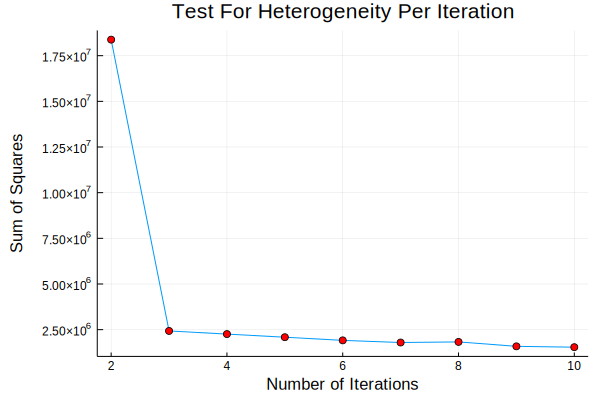

In [12]:
plot(num, ss, ylabel="Sum of Squares", xlabel="Number of Iterations",
     title = "Test For Heterogeneity Per Iteration", legend=false)

scatter!(num, ss, color="red")